# Overfitting Example
We try to overfit a single simple song with a encoder-decoder LSTM.
This time we use PyTorch and embeddings.
The code is inspired by this tutorial: [https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

Additionally to experiment 2 we use a decoder with attention and will visualize the attention outputs.

In [1]:
from music21 import stream, note, metadata

def get():
    piece = stream.Score()
    p1 = stream.Part()
    p1.id = 'part1'

    notes = [note.Note('C4', type='quarter'),
             note.Note('D4', type='quarter'),
             note.Note('E4', type='quarter'),
             note.Note('F4', type='quarter'),
             note.Note('G4', type='half'),
             note.Note('G4', type='half'),
    
             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('G4', type='half'),

             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('A4', type='quarter'),
             note.Note('G4', type='half'),

             note.Note('F4', type='quarter'),
             note.Note('F4', type='quarter'),
             note.Note('F4', type='quarter'),
             note.Note('F4', type='quarter'),
             note.Note('E4', type='half'),
             note.Note('E4', type='half'),

             note.Note('D4', type='quarter'),
             note.Note('D4', type='quarter'),
             note.Note('D4', type='quarter'),
             note.Note('D4', type='quarter'),
             note.Note('C4', type='half')
            ]
    p1.append(notes)
    piece.insert(0, metadata.Metadata())
    piece.metadata.title = 'Alle meine Entchen'
    piece.insert(0, p1)
    return piece, notes

In [2]:
piece, notes = get()
#piece.show('midi')
#piece.show() # doesn't work inside the notebook for me

![images/overfitting_piece.PNG](images/overfitting_piece.PNG)

# Part 1: Encoding & Data Preparation

We use:
- 128 midi notes
- 128 additional midi notes. This represents the midi notes which are Tied to the previous note.
- 258 additional symbols (Start, Stop)

Therefore we encode our notes as 131-dimensional vector.

* The encoder get's hald of the song as input
* the decoder has to produce the missing half

In [3]:
import music21
from music21 import pitch, interval, stream
import numpy as np

In [4]:
def getTotalTokens():
    return 128*2+ 2  # 128 midi notes + Start + Stop

def getStartIndex():
    return 256

def getStopIndex():
    return 257

In [5]:
def encodeNoteList(notes, delta):
    sequence = []

    for n in notes:
        if (n.isNote):
            sequence.append(n.pitch.midi)
            ticksOn = int(n.duration.quarterLength / delta)
            #print("ticksOn:", ticksOn)
            for i in range(0, ticksOn-1):
                sequence.append(n.pitch.midi + 128)

        if (n.isChord):
            raise NotImplementedError

    return sequence


def split(notes, splitRatio=0.5):
    splitIndex = int(len(notes)*splitRatio)
    x = notes[0:splitIndex]
    y = notes[splitIndex:] + [getStopIndex()]
    return x, y

In [6]:
input = encodeNoteList(notes, delta=1)
input, target = split(input, splitRatio=0.49)
pairs = [(input,target)]
print(pairs)

[([60, 62, 64, 65, 67, 195, 67, 195, 69, 69, 69, 69, 67, 195, 69, 69], [69, 69, 67, 195, 65, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257])]


# Part 2: Model definition & Training
We use a encoder-decoder model from here: [https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) 

In [7]:
import random
import torch
from torch import optim, nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

teacher_forcing_ratio = 1.0
MAX_LENGTH = 20

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)

        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, max_length, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
hidden_size = 64
encoder = EncoderRNN(getTotalTokens(), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, getTotalTokens(), max_length=MAX_LENGTH, dropout_p=0.1).to(device)

In [11]:
def train(input, target, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = len(input)
    target_length = len(target)

    input = torch.tensor(input)
    target = torch.tensor(target).view(-1, 1)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[getStartIndex()]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target[di])
            decoder_input = target[di]  # Teacher forcing

    else:
        #raise NotImplementedError
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target[di])
            if decoder_input.item() == getStopIndex():
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
def trainIters(pairs, encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()

    numberofExamples = len(pairs)
    for iter in range(0, epochs):
        for example in range(0, numberofExamples):
            training_pair = pairs[example]
            input = training_pair[0]
            target = training_pair[1]

            loss = train(input, target,encoder,decoder, encoder_optimizer, decoder_optimizer,criterion)

        print("Epoch", iter+1, " finished. Loss:", loss)

In [13]:
trainIters(pairs, encoder, decoder, epochs=200)

Epoch 1  finished. Loss: 5.5492409153988485
Epoch 2  finished. Loss: 5.429676256681743
Epoch 3  finished. Loss: 5.291647660104852
Epoch 4  finished. Loss: 5.149326926783512
Epoch 5  finished. Loss: 4.957502666272615
Epoch 6  finished. Loss: 4.745946783768503
Epoch 7  finished. Loss: 4.425963150827508
Epoch 8  finished. Loss: 4.037647849635074
Epoch 9  finished. Loss: 3.611983449835526
Epoch 10  finished. Loss: 3.1609583402934827
Epoch 11  finished. Loss: 2.872416847630551
Epoch 12  finished. Loss: 2.633803317421361
Epoch 13  finished. Loss: 2.468781922992907
Epoch 14  finished. Loss: 2.3164568449321545
Epoch 15  finished. Loss: 2.1727232682077506
Epoch 16  finished. Loss: 2.0657208091334294
Epoch 17  finished. Loss: 1.9262683266087581
Epoch 18  finished. Loss: 1.8319314655504728
Epoch 19  finished. Loss: 1.7011317202919407
Epoch 20  finished. Loss: 1.619348224840666
Epoch 21  finished. Loss: 1.5359271200079667
Epoch 22  finished. Loss: 1.4095714970638877
Epoch 23  finished. Loss: 1.327

Epoch 182  finished. Loss: 0.15431102953459086
Epoch 183  finished. Loss: 0.16828833128276624
Epoch 184  finished. Loss: 0.13974972775107936
Epoch 185  finished. Loss: 0.12149369089226973
Epoch 186  finished. Loss: 0.1086601458097759
Epoch 187  finished. Loss: 0.10691908786171361
Epoch 188  finished. Loss: 0.10635230415745785
Epoch 189  finished. Loss: 0.107569042005037
Epoch 190  finished. Loss: 0.09997247394762541
Epoch 191  finished. Loss: 0.10432524430124383
Epoch 192  finished. Loss: 0.11036902979800575
Epoch 193  finished. Loss: 0.11043548583984375
Epoch 194  finished. Loss: 0.10721894314414576
Epoch 195  finished. Loss: 0.11796645114296361
Epoch 196  finished. Loss: 0.12069772419176604
Epoch 197  finished. Loss: 0.14827818619577507
Epoch 198  finished. Loss: 0.16248186011063426
Epoch 199  finished. Loss: 0.17672312887091385
Epoch 200  finished. Loss: 0.12395447178890831


# Part 3: Inference
* Use the trained model and predict the second ahlf of the training data
* Represent the generated as a music21 piece in order to display and play it

In [14]:
def evaluate(input, max_length=MAX_LENGTH):
    #print(input)
    with torch.no_grad():
        input_tensor = torch.tensor(input)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[getStartIndex()]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == getStopIndex():
                decoded_words.append(getStopIndex())
                break
            else:
                decoded_words.append(topi.item())

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def decodeSequence(seq, input=None, delta=1):
    notes = []

    for i in range(0, len(seq)):

        index = seq[i]

        if index == getStopIndex():
            break

        if i == 0 and index <= 128:
            n = music21.note.Note()
            n.pitch.midi = index
            notes.append(n)
        elif i == 0:
            print(index)
            raise NotImplementedError

        else:
            previousNote = notes[-1].pitch.midi

            if index <= 128:
                n = music21.note.Note()
                n.pitch.midi = index
                notes.append(n)
            elif index < 128 * 2 and index - 128 == previousNote:
                notes[-1].quarterLength += delta
            else:
                raise NotImplementedError


    if input is not None:
        #print("reiin", input)
        notes = input + [music21.note.Rest(type='half')] + notes

    piece = music21.stream.Score()
    p1 = music21.stream.Part()
    p1.id = 'part1'

    p1.append(notes)
    piece.insert(0, music21.metadata.Metadata())
    piece.metadata.title = 'Title'
    piece.insert(0, p1)
    return piece, notes

In [19]:
decoded_words, decoder_attentions = evaluate(input)

print("d:",decoded_words)

inputNotes = notes[:int(len(notes)*0.49)]

p, _ = decodeSequence(decoded_words, inputNotes, delta=1)
#p.show()

print("i:",input)
print("t:",target)

d: [69, 69, 67, 195, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257]
i: [60, 62, 64, 65, 67, 195, 67, 195, 69, 69, 69, 69, 67, 195, 69, 69]
t: [69, 69, 67, 195, 65, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257]


![images/overfitting_pytorch.PNG](images/overfitting_pytorch.PNG)

The decoder perfectly reproduced the piece!

### Part 4: Show Attention

In [20]:
inputNotes = notes[:int(len(notes)*0.49)]

print("i:", input)
print("d:", decoded_words)
print("t:", target)


i: [60, 62, 64, 65, 67, 195, 67, 195, 69, 69, 69, 69, 67, 195, 69, 69]
d: [69, 69, 67, 195, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257]
t: [69, 69, 67, 195, 65, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257]


In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(input_sentence)
    print('input =', input_sentence)
    print('output =', output_words)
    showAttention(input_sentence, output_words, attentions)

input = [60, 62, 64, 65, 67, 195, 67, 195, 69, 69, 69, 69, 67, 195, 69, 69]
output = [69, 69, 67, 195, 65, 65, 65, 64, 192, 64, 192, 62, 62, 62, 62, 60, 188, 257]


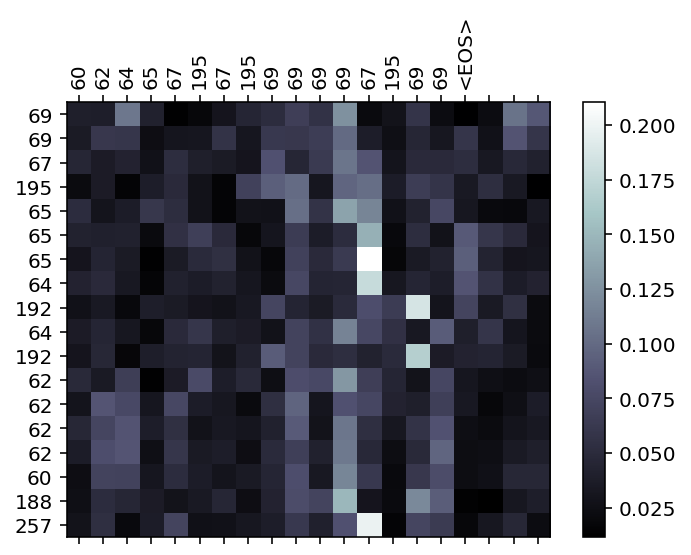

In [24]:
evaluateAndShowAttention([60, 62, 64, 65, 67, 195, 67, 195, 69, 69, 69, 69, 67, 195, 69, 69])

## Limitations & future work
- [ ] No chords supported only single notes
- [ ] No Ties between different notes supported